# Collecting the data

In [0]:
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar

--2018-03-01 14:33:17--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7012157440 (6.5G) [application/x-tar]
Saving to: ‘imdb_crop.tar.1’

imdb_crop.tar.1       1%[                    ]  71.94M  1.74MB/s    eta 63m 40s

imdb_crop.tar.1      13%[=>                  ] 914.43M  1.70MB/s    eta 58m 43s

# Processing the data

In [2]:
!ls

datalab  imdb_crop.tar


In [3]:
 !tar -xvf imdb_crop.tar

imdb_crop/00/nm2296000_rm2316548608_1980-12-18_2011.jpg
imdb_crop/00/nm0391400_rm2676926464_1931-1-16_1968.jpg
imdb_crop/00/nm0490500_rm1768268800_1964-12-8_2013.jpg
imdb_crop/00/nm1490300_rm2576711680_1975-11-13_2010.jpg
imdb_crop/00/nm1490300_rm4249526528_1975-11-13_2013.jpg
imdb_crop/00/nm1490300_rm800775680_1975-11-13_2013.jpg
imdb_crop/00/nm0592400_rm622429440_1955-9-18_2001.jpg
imdb_crop/00/nm0691600_rm1305269504_1988-12-16_2013.jpg
imdb_crop/00/nm0691600_rm1690535168_1988-12-16_2010.jpg
imdb_crop/00/nm0691600_rm2550586368_1988-12-16_2013.jpg
imdb_crop/00/nm0691600_rm266963968_1988-12-16_2005.jpg
imdb_crop/00/nm0691600_rm2832716288_1988-12-16_2013.jpg
imdb_crop/00/nm0691600_rm3051916288_1988-12-16_2005.jpg
imdb_crop/00/nm0691600_rm3052837120_1988-12-16_2008.jpg
imdb_crop/00/nm0691600_rm3186220288_1988-12-16_2013.jpg
imdb_crop/00/nm0691600_rm3387460608_1988-12-16_2005.jpg
imdb_crop/00/nm0691600_rm3806891008_1988-12-16_2005.jpg
imdb_crop/00/nm0691600_rm3919165952_1988-12-16_2000.jp

imdb_crop/00/nm0000200_rm3250238720_1955-5-17_2012.jpg
imdb_crop/00/nm0000200_rm3267015936_1955-5-17_2012.jpg
imdb_crop/00/nm0000200_rm3406796800_1955-5-17_2004.jpg
imdb_crop/00/nm0000200_rm3423574016_1955-5-17_2004.jpg
imdb_crop/00/nm0000200_rm3444414976_1955-5-17_1997.jpg
imdb_crop/00/nm0000200_rm3458701312_1955-5-17_2006.jpg
imdb_crop/00/nm0000200_rm3576141824_1955-5-17_2006.jpg
imdb_crop/00/nm0000200_rm3591346176_1955-5-17_2004.jpg
imdb_crop/00/nm0000200_rm3592919040_1955-5-17_2006.jpg
imdb_crop/00/nm0000200_rm3770332416_1955-5-17_2012.jpg
imdb_crop/00/nm0000200_rm3782773248_1955-5-17_2006.jpg
imdb_crop/00/nm0000200_rm4072322304_1955-5-17_2012.jpg
imdb_crop/00/nm0000200_rm4139096064_1955-5-17_1999.jpg
imdb_crop/00/nm0000200_rm4157135616_1955-5-17_2014.jpg
imdb_crop/00/nm0000200_rm4246444544_1955-5-17_1999.jpg
imdb_crop/00/nm0000200_rm460894208_1955-5-17_2011.jpg
imdb_crop/00/nm0000200_rm614256128_1955-5-17_2014.jpg
imdb_crop/00/nm0000200_rm680827136_1955-5-17_2003.jpg
imdb_crop/00/

imdb_crop/00/nm0194900_rm1105459456_1980-4-17_2014.jpg
imdb_crop/00/nm0194900_rm1191231232_1980-4-17_2011.jpg
imdb_crop/00/nm0194900_rm1206749952_1980-4-17_2009.jpg
imdb_crop/00/nm0194900_rm1748933376_1980-4-17_2007.jpg
imdb_crop/00/nm0194900_rm2080423680_1980-4-17_2011.jpg
imdb_crop/00/nm0194900_rm2488260608_1980-4-17_2013.jpg
imdb_crop/00/nm0194900_rm2639255552_1980-4-17_2013.jpg
imdb_crop/00/nm0194900_rm2647717888_1980-4-17_2014.jpg
imdb_crop/00/nm0194900_rm3421166848_1980-4-17_2013.jpg
imdb_crop/00/nm0194900_rm3898465536_1980-4-17_2013.jpg
imdb_crop/00/nm0194900_rm4225159168_1980-4-17_2013.jpg
imdb_crop/00/nm0194900_rm518685696_1980-4-17_2011.jpg
imdb_crop/00/nm0194900_rm684362496_1980-4-17_2009.jpg
imdb_crop/00/nm0194900_rm950441984_1980-4-17_2007.jpg
imdb_crop/00/nm0197700_rm2302070272_1953-12-23_2015.jpg
imdb_crop/00/nm1191900_rm3540626432_1980-7-27_2012.jpg
imdb_crop/00/nm1191900_rm3557403648_1980-7-27_2012.jpg
imdb_crop/00/nm1191900_rm3574180864_1980-7-27_2012.jpg
imdb_crop/00

imdb_crop/00/nm0000800_rm967481600_1949-10-4_2005.jpg
imdb_crop/00/nm0000900_rm2905385472_1951-6-26_1981.jpg
imdb_crop/00/nm0001100_rm1069259520_1943-2-3_2004.jpg
imdb_crop/00/nm0001100_rm1479383808_1943-2-3_2007.jpg
imdb_crop/00/nm0001100_rm1951958272_1943-2-3_1976.jpg
imdb_crop/00/nm0001100_rm204118016_1943-2-3_2004.jpg
imdb_crop/00/nm0001100_rm2052621568_1943-2-3_1976.jpg
imdb_crop/00/nm0001100_rm2153427456_1943-2-3_2011.jpg
imdb_crop/00/nm0001100_rm2204801792_1943-2-3_1999.jpg
imdb_crop/00/nm0001100_rm2254090752_1943-2-3_2011.jpg
imdb_crop/00/nm0001100_rm2308738304_1943-2-3_2004.jpg
imdb_crop/00/nm0001100_rm2334823936_1943-2-3_2007.jpg
imdb_crop/00/nm0001100_rm2470235136_1943-2-3_1979.jpg
imdb_crop/00/nm0001100_rm2573317888_1943-2-3_2012.jpg
imdb_crop/00/nm0001100_rm2804783872_1943-2-3_2007.jpg
imdb_crop/00/nm0001100_rm2826214656_1943-2-3_1998.jpg
imdb_crop/00/nm0001100_rm2837031424_1943-2-3_2012.jpg
imdb_crop/00/nm0001100_rm2917174016_1943-2-3_2008.jpg
imdb_crop/00/nm0001100_rm292

imdb_crop/00/nm0600800_rm4008090368_1949-10-6_2004.jpg
imdb_crop/00/nm0606700_rm1040095488_1969-1-28_2003.jpg
imdb_crop/00/nm0606700_rm1176605440_1969-1-28_2003.jpg
imdb_crop/00/nm0606700_rm1247983616_1969-1-28_2011.jpg
imdb_crop/00/nm0606700_rm2297337856_1969-1-28_2003.jpg
imdb_crop/00/nm0606700_rm2314115072_1969-1-28_2003.jpg
imdb_crop/00/nm0606700_rm2583468032_1969-1-28_2003.jpg
imdb_crop/00/nm0606700_rm3489175552_1969-1-28_2007.jpg
imdb_crop/00/nm0606700_rm3493435904_1969-1-28_2000.jpg
imdb_crop/00/nm0606700_rm36015104_1969-1-28_2002.jpg
imdb_crop/00/nm0606700_rm721328384_1969-1-28_2003.jpg
imdb_crop/00/nm0606700_rm905877760_1969-1-28_2003.jpg
imdb_crop/00/nm0701500_rm2893662208_1920-5-11_1979.jpg
imdb_crop/00/nm0703800_rm3762063616_1959-6-6_2009.jpg
imdb_crop/00/nm1801800_rm1016889344_1983-7-22_2010.jpg
imdb_crop/00/nm1801800_rm227835904_1983-7-22_2010.jpg
imdb_crop/00/nm1801800_rm2733300480_1983-7-22_2011.jpg
imdb_crop/00/nm1801800_rm2766854912_1983-7-22_2011.jpg
imdb_crop/00/nm1

imdb_crop/01/nm0001101_rm4286236672_1947-12-29_1982.jpg
imdb_crop/01/nm0001101_rm443394816_1947-12-29_1982.jpg
imdb_crop/01/nm0001101_rm628803584_1947-12-29_1982.jpg
imdb_crop/01/nm0001101_rm662358016_1947-12-29_1982.jpg
imdb_crop/01/nm0001101_rm953921792_1947-12-29_2000.jpg
imdb_crop/01/nm0001201_rm1695909120_1945-2-9_1984.jpg
imdb_crop/01/nm0001201_rm204768256_1945-2-9_1990.jpg
imdb_crop/01/nm0001201_rm2714484480_1945-2-9_1969.jpg
imdb_crop/01/nm0001201_rm2990249984_1945-2-9_2006.jpg
imdb_crop/01/nm0001201_rm3325332992_1945-2-9_1986.jpg
imdb_crop/01/nm0001201_rm3888827392_1945-2-9_1968.jpg
imdb_crop/01/nm0001201_rm54234624_1945-2-9_1994.jpg
imdb_crop/01/nm0001201_rm810915840_1945-2-9_1995.jpg
imdb_crop/01/nm0001301_rm1875281408_1935-4-21_1993.jpg
imdb_crop/01/nm0001301_rm2669907456_1935-4-21_1992.jpg
imdb_crop/01/nm0001401_rm1011192832_1975-6-4_2008.jpg
imdb_crop/01/nm0001401_rm106935040_1975-6-4_2011.jpg
imdb_crop/01/nm0001401_rm1168869888_1975-6-4_2008.jpg
imdb_crop/01/nm0001401_rm


imdb_crop/01/nm0001001_rm431400704_1940-3-26_2013.jpg
imdb_crop/01/nm0001001_rm504270080_1940-3-26_2009.jpg
imdb_crop/01/nm0001001_rm53581824_1940-3-26_2001.jpg
imdb_crop/01/nm0001001_rm582523648_1940-3-26_2000.jpg
imdb_crop/01/nm0001101_rm1014679552_1947-12-29_1982.jpg
imdb_crop/01/nm0001101_rm122919424_1947-12-29_1996.jpg
imdb_crop/01/nm0001101_rm1588116480_1947-12-29_2000.jpg
imdb_crop/01/nm0001101_rm1604893696_1947-12-29_2000.jpg
imdb_crop/01/nm0001101_rm1637592832_1947-12-29_2000.jpg
imdb_crop/01/nm0001101_rm1654370048_1947-12-29_2000.jpg
imdb_crop/01/nm0001101_rm1722397184_1947-12-29_2000.jpg
imdb_crop/01/nm0001101_rm1739174400_1947-12-29_2000.jpg
imdb_crop/01/nm0001101_rm1750247680_1947-12-29_2000.jpg
imdb_crop/01/nm0001101_rm1800579328_1947-12-29_2000.jpg
imdb_crop/01/nm0001101_rm1920649216_1947-12-29_1982.jpg
imdb_crop/01/nm0001101_rm1970980864_1947-12-29_1982.jpg
imdb_crop/01/nm0001101_rm1995757312_1947-12-29_2014.jpg
imdb_crop/01/nm0001101_rm2303230976_1947-12-29_1986.jpg
i

imdb_crop/01/nm0001001_rm2921699840_1940-3-26_1997.jpg
imdb_crop/01/nm0001001_rm2953288448_1940-3-26_2000.jpg
imdb_crop/01/nm0001001_rm3186665216_1940-3-26_2013.jpg
imdb_crop/01/nm0001001_rm3207891200_1940-3-26_2008.jpg
imdb_crop/01/nm0001001_rm3330509056_1940-3-26_2009.jpg
imdb_crop/01/nm0001001_rm351058432_1940-3-26_1992.jpg
imdb_crop/01/nm0001001_rm3596524032_1940-3-26_2000.jpg
imdb_crop/01/nm0001001_rm4147760128_1940-3-26_1974.jpg
imdb_crop/01/nm0001001_rm420580864_1940-3-26_1992.jpg
imdb_crop/01/nm0001001_rm4206985216_1940-3-26_2009.jpg
imdb_crop/01/nm0001001_rm4264147456_1940-3-26_1990.jpg
imdb_crop/01/nm0001001_rm487492864_1940-3-26_2009.jpg
imdb_crop/01/nm0001001_rm548969216_1940-3-26_2000.jpg
imdb_crop/01/nm0001001_rm599300864_1940-3-26_2000.jpg
imdb_crop/01/nm0001001_rm70359040_1940-3-26_2001.jpg
imdb_crop/01/nm0001001_rm800627456_1940-3-26_2000.jpg
imdb_crop/01/nm0001101_rm1134396416_1947-12-29_1982.jpg
imdb_crop/01/nm0001101_rm1283115008_1947-12-29_1982.jpg
imdb_crop/01/nm0

imdb_crop/01/nm0001401_rm1403357952_1975-6-4_2010.jpg
imdb_crop/01/nm0001401_rm1437964544_1975-6-4_2003.jpg
imdb_crop/01/nm0001401_rm1464113408_1975-6-4_2007.jpg
imdb_crop/01/nm0001401_rm150309888_1975-6-4_2005.jpg
imdb_crop/01/nm0001401_rm1540141056_1975-6-4_2011.jpg
imdb_crop/01/nm0001401_rm1546112512_1975-6-4_2014.jpg
imdb_crop/01/nm0001401_rm1554549248_1975-6-4_2008.jpg
imdb_crop/01/nm0001401_rm1580177408_1975-6-4_2008.jpg
imdb_crop/01/nm0001401_rm1641913088_1975-6-4_2007.jpg
imdb_crop/01/nm0001401_rm1650644992_1975-6-4_2014.jpg
imdb_crop/01/nm0001401_rm1723641856_1975-6-4_2008.jpg
imdb_crop/01/nm0001401_rm1724025856_1975-6-4_2004.jpg
imdb_crop/01/nm0001401_rm1730851584_1975-6-4_2011.jpg
imdb_crop/01/nm0001401_rm1740803072_1975-6-4_2004.jpg
imdb_crop/01/nm0001401_rm1775470592_1975-6-4_2009.jpg
imdb_crop/01/nm0001401_rm1804966656_1975-6-4_2003.jpg
imdb_crop/01/nm0001401_rm1825802240_1975-6-4_2009.jpg
imdb_crop/01/nm0001401_rm1838521088_1975-6-4_2003.jpg
imdb_crop/01/nm0001401_rm1842

imdb_crop/01/nm0001001_rm2528477440_1940-3-26_1988.jpg
imdb_crop/01/nm0001001_rm2528552704_1940-3-26_2013.jpg
imdb_crop/01/nm0001001_rm2565970176_1940-3-26_2002.jpg
imdb_crop/01/nm0001001_rm2616301824_1940-3-26_2002.jpg
imdb_crop/01/nm0001001_rm2633079040_1940-3-26_2002.jpg
imdb_crop/01/nm0001001_rm2650511616_1940-3-26_2003.jpg
imdb_crop/01/nm0001001_rm2693782016_1940-3-26_2012.jpg
imdb_crop/01/nm0001001_rm288275200_1940-3-26_2011.jpg
imdb_crop/01/nm0001001_rm2939203584_1940-3-26_1973.jpg
imdb_crop/01/nm0001001_rm3195377920_1940-3-26_2003.jpg
imdb_crop/01/nm0001001_rm3844443648_1940-3-26_1993.jpg
imdb_crop/01/nm0001001_rm3913711872_1940-3-26_1972.jpg
imdb_crop/01/nm0001001_rm3979987968_1940-3-26_1974.jpg
imdb_crop/01/nm0001001_rm4194141440_1940-3-26_1995.jpg
imdb_crop/01/nm0001001_rm565746432_1940-3-26_2000.jpg
imdb_crop/01/nm0001001_rm64206848_1940-3-26_2010.jpg
imdb_crop/01/nm0001001_rm673486848_1940-3-26_2002.jpg
imdb_crop/01/nm0001001_rm690264064_1940-3-26_2002.jpg
imdb_crop/01/nm0

imdb_crop/01/nm0001401_rm4141259520_1975-6-4_2004.jpg
imdb_crop/01/nm0001401_rm414554112_1975-6-4_2006.jpg
imdb_crop/01/nm0001401_rm4160395520_1975-6-4_1999.jpg
imdb_crop/01/nm0001401_rm4218067712_1975-6-4_2006.jpg
imdb_crop/01/nm0001401_rm4268399360_1975-6-4_2006.jpg
imdb_crop/01/nm0001401_rm445094144_1975-6-4_2002.jpg
imdb_crop/01/nm0001401_rm458200064_1975-6-4_2008.jpg
imdb_crop/01/nm0001401_rm465350656_1975-6-4_2008.jpg
imdb_crop/01/nm0001401_rm503355392_1975-6-4_2006.jpg
imdb_crop/01/nm0001401_rm525308928_1975-6-4_2008.jpg
imdb_crop/01/nm0001401_rm578455296_1975-6-4_2010.jpg
imdb_crop/01/nm0000701_rm3019158272_1975-10-5_1997.jpg
imdb_crop/01/nm0000701_rm304798720_1975-10-5_2013.jpg
imdb_crop/01/nm0000701_rm3052712704_1975-10-5_1997.jpg
imdb_crop/01/nm0000701_rm306813440_1975-10-5_2004.jpg
imdb_crop/01/nm0000701_rm3099892480_1975-10-5_2004.jpg
imdb_crop/01/nm0000701_rm3222968320_1975-10-5_2000.jpg
imdb_crop/01/nm0000701_rm3321271552_1975-10-5_2008.jpg
imdb_crop/01/nm0000701_rm33305

imdb_crop/02/nm1694302_rm3569256192_1976-1-26_2005.jpg
imdb_crop/02/nm1694302_rm3706629632_1976-1-26_2005.jpg
imdb_crop/02/nm1694302_rm3882060544_1976-1-26_2005.jpg
imdb_crop/02/nm1694302_rm47560960_1976-1-26_2006.jpg
imdb_crop/02/nm1694302_rm551127808_1976-1-26_2005.jpg
imdb_crop/02/nm1694302_rm65243136_1976-1-26_2005.jpg
imdb_crop/02/nm1055302_rm330534400_1974-3-21_2009.jpg
imdb_crop/02/nm3057402_rm1101761024_1991-11-4_2008.jpg
imdb_crop/02/nm3057402_rm31230464_1991-11-4_2008.jpg
imdb_crop/02/nm3057402_rm819759616_1991-11-4_2008.jpg
imdb_crop/02/nm0153002_rm1618198784_1964-7-11_1988.jpg
imdb_crop/02/nm0153002_rm1651753216_1964-7-11_1988.jpg
imdb_crop/02/nm0153002_rm2063451392_1964-7-11_1988.jpg
imdb_crop/02/nm0153002_rm3147214336_1964-7-11_1988.jpg
imdb_crop/02/nm0153002_rm326353152_1964-7-11_1988.jpg
imdb_crop/02/nm0153002_rm880066816_1964-7-11_1988.jpg
imdb_crop/02/nm0153002_rm896778496_1964-7-11_1988.jpg
imdb_crop/02/nm0153002_rm91472128_1964-7-11_1988.jpg
imdb_crop/02/nm0159402_r

imdb_crop/02/nm0491402_rm1914485248_1959-6-11_2004.jpg
imdb_crop/02/nm0491402_rm1949076736_1959-6-11_2004.jpg
imdb_crop/02/nm0491402_rm1999408384_1959-6-11_2004.jpg
imdb_crop/02/nm0491402_rm2015148544_1959-6-11_2004.jpg
imdb_crop/02/nm0491402_rm2040109824_1959-6-11_2007.jpg
imdb_crop/02/nm0491402_rm2052425984_1959-6-11_2004.jpg
imdb_crop/02/nm0491402_rm2070656768_1959-6-11_2004.jpg
imdb_crop/02/nm0491402_rm2076675328_1959-6-11_2004.jpg
imdb_crop/02/nm0491402_rm2082257408_1959-6-11_2004.jpg
imdb_crop/02/nm0491402_rm2102757632_1959-6-11_2004.jpg
imdb_crop/02/nm0491402_rm2111485440_1959-6-11_2004.jpg
imdb_crop/02/nm0491402_rm2154793728_1959-6-11_2009.jpg
imdb_crop/02/nm0491402_rm2200156416_1959-6-11_2004.jpg
imdb_crop/02/nm0491402_rm2250869248_1959-6-11_2004.jpg
imdb_crop/02/nm0491402_rm2267265280_1959-6-11_2004.jpg
imdb_crop/02/nm0491402_rm2333575936_1959-6-11_2004.jpg
imdb_crop/02/nm0491402_rm2518452736_1959-6-11_2009.jpg
imdb_crop/02/nm0491402_rm2586035456_1959-6-11_2015.jpg
imdb_crop/

imdb_crop/02/nm0000102_rm2351168512_1958-7-8_2015.jpg
imdb_crop/02/nm0000102_rm2365836032_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm2379323648_1958-7-8_2007.jpg
imdb_crop/02/nm0000102_rm2387188480_1958-7-8_2005.jpg
imdb_crop/02/nm0000102_rm2497421568_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm2559482112_1958-7-8_1999.jpg
imdb_crop/02/nm0000102_rm2579225344_1958-7-8_1986.jpg
imdb_crop/02/nm0000102_rm2648416512_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm2722472704_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm2733568000_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm2762775296_1958-7-8_1998.jpg
imdb_crop/02/nm0000102_rm2777477120_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm2780207104_1958-7-8_2000.jpg
imdb_crop/02/nm0000102_rm2811031552_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm2824976640_1958-7-8_2011.jpg
imdb_crop/02/nm0000102_rm2831931136_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm2943846656_1958-7-8_2009.jpg
imdb_crop/02/nm0000102_rm2965042176_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm309

imdb_crop/02/nm0000102_rm1683795200_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm1700572416_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm1801552896_1958-7-8_1984.jpg
imdb_crop/02/nm0000102_rm1844878080_1958-7-8_2005.jpg
imdb_crop/02/nm0000102_rm1997207296_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm2144466176_1958-7-8_1982.jpg
imdb_crop/02/nm0000102_rm215848192_1958-7-8_2008.jpg
imdb_crop/02/nm0000102_rm2177997056_1958-7-8_2007.jpg
imdb_crop/02/nm0000102_rm2255718912_1958-7-8_2009.jpg
imdb_crop/02/nm0000102_rm2295437568_1958-7-8_2007.jpg
imdb_crop/02/nm0000102_rm2296094976_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm2448665856_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm245209344_1958-7-8_1994.jpg
imdb_crop/02/nm0000102_rm2463867136_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm2531891968_1958-7-8_2005.jpg
imdb_crop/02/nm0000102_rm2535573504_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm2566106368_1958-7-8_2013.jpg
imdb_crop/02/nm0000102_rm27105536_1958-7-8_1994.jpg
imdb_crop/02/nm0000102_rm2737742

imdb_crop/02/nm1694302_rm2954999296_1976-1-26_2012.jpg
imdb_crop/02/nm1694302_rm3002501120_1976-1-26_2005.jpg
imdb_crop/02/nm1694302_rm3002660864_1976-1-26_2014.jpg
imdb_crop/02/nm1694302_rm3150874624_1976-1-26_2005.jpg
imdb_crop/02/nm1694302_rm3192490752_1976-1-26_2005.jpg
imdb_crop/02/nm1694302_rm3203827712_1976-1-26_2005.jpg
imdb_crop/02/nm1694302_rm3209267968_1976-1-26_2005.jpg
imdb_crop/02/nm1694302_rm32811008_1976-1-26_2012.jpg
imdb_crop/02/nm1694302_rm3468004096_1976-1-26_2005.jpg
imdb_crop/02/nm1694302_rm3512634112_1976-1-26_2005.jpg
imdb_crop/02/nm1694302_rm3626142464_1976-1-26_2005.jpg
imdb_crop/02/nm1694302_rm3642919680_1976-1-26_2005.jpg
imdb_crop/02/nm1694302_rm392605696_1976-1-26_2011.jpg
imdb_crop/02/nm1694302_rm505261568_1976-1-26_2011.jpg
imdb_crop/02/nm1694302_rm645639424_1976-1-26_2011.jpg
imdb_crop/02/nm1694302_rm656640768_1976-1-26_2005.jpg
imdb_crop/02/nm1694302_rm871671808_1976-1-26_2012.jpg
imdb_crop/02/nm1694302_rm98797568_1976-1-26_2005.jpg
imdb_crop/02/nm0791

imdb_crop/03/nm0295103_rm3288111872_1969-3-16_2006.jpg
imdb_crop/03/nm0295103_rm3433279744_1969-3-16_2006.jpg
imdb_crop/03/nm0295103_rm3455884032_1969-3-16_2006.jpg
imdb_crop/03/nm0295103_rm3798448896_1969-3-16_2006.jpg
imdb_crop/03/nm0295103_rm3865947648_1969-3-16_2006.jpg
imdb_crop/03/nm0295103_rm559254784_1969-3-16_2006.jpg
imdb_crop/03/nm0295103_rm576032000_1969-3-16_2006.jpg
imdb_crop/03/nm0295103_rm717597952_1969-3-16_2006.jpg
imdb_crop/03/nm0295103_rm92646400_1969-3-16_2006.jpg
imdb_crop/03/nm0390903_rm135715840_1967-8-25_2013.jpg
imdb_crop/03/nm0390903_rm284724480_1967-8-25_2006.jpg
imdb_crop/03/nm0390903_rm2955905792_1967-8-25_2009.jpg
imdb_crop/03/nm0390903_rm2967964928_1967-8-25_2007.jpg
imdb_crop/03/nm0390903_rm370596864_1967-8-25_2013.jpg
imdb_crop/03/nm0390903_rm4132426752_1967-8-25_2011.jpg
imdb_crop/03/nm0390903_rm502828288_1967-8-25_2006.jpg
imdb_crop/03/nm0594503_rm1996866048_1941-1-5_2013.jpg
imdb_crop/03/nm0696303_rm2118822656_1939-7-10_1989.jpg
imdb_crop/03/nm06963

imdb_crop/03/nm0001803_rm315064320_1944-5-16_2010.jpg
imdb_crop/03/nm0001803_rm3222068992_1944-5-16_2013.jpg
imdb_crop/03/nm0383603_rm675188480_1992-2-14_2005.jpg
imdb_crop/03/nm0383603_rm87985920_1992-2-14_2005.jpg
imdb_crop/03/nm0385103_rm1114684672_1952-11-5_2011.jpg
imdb_crop/03/nm1387503_rm808046848_1984-3-12_2014.jpg
imdb_crop/03/nm0680603_rm1108515584_1959-11-10_2007.jpg
imdb_crop/03/nm0680603_rm1459062016_1959-11-10_1975.jpg
imdb_crop/03/nm0680603_rm147167232_1959-11-10_2005.jpg
imdb_crop/03/nm2686103_rm2167054336_1982-9-27_2011.jpg
imdb_crop/03/nm0881703_rm584287232_1957-2-17_2010.jpg
imdb_crop/03/nm0881703_rm752059392_1957-2-17_2010.jpg
imdb_crop/03/nm0882203_rm3473601024_1965-10-30_2015.jpg
imdb_crop/03/nm0885203_rm1895030272_1916-2-17_1990.jpg
imdb_crop/03/nm0885203_rm1978916352_1916-2-17_1990.jpg
imdb_crop/03/nm0885203_rm2046025216_1916-2-17_1990.jpg
imdb_crop/03/nm1883803_rm1075956224_1982-0-0_2014.jpg
imdb_crop/03/nm1883803_rm1277282816_1982-0-0_2014.jpg
imdb_crop/03/nm1

imdb_crop/03/nm0001103_rm394119168_1951-4-21_1984.jpg
imdb_crop/03/nm0001103_rm4109549312_1951-4-21_2011.jpg
imdb_crop/03/nm0001103_rm4152150016_1951-4-21_1984.jpg
imdb_crop/03/nm0001103_rm511559680_1951-4-21_1984.jpg
imdb_crop/03/nm0001103_rm746440704_1951-4-21_1984.jpg
imdb_crop/03/nm0001103_rm796772352_1951-4-21_1984.jpg
imdb_crop/03/nm0001103_rm883274496_1951-4-21_2011.jpg
imdb_crop/03/nm0001103_rm930990080_1951-4-21_1984.jpg
imdb_crop/03/nm0001303_rm1076345600_1971-8-29_2011.jpg
imdb_crop/03/nm0001303_rm1143454464_1971-8-29_2011.jpg
imdb_crop/03/nm0001303_rm1181332224_1971-8-29_2011.jpg
imdb_crop/03/nm0001303_rm1220450304_1971-8-29_2000.jpg
imdb_crop/03/nm0001303_rm1255705344_1971-8-29_2009.jpg
imdb_crop/03/nm0001303_rm1379052032_1971-8-29_2012.jpg
imdb_crop/03/nm0001303_rm138263040_1971-8-29_2007.jpg
imdb_crop/03/nm0001303_rm1424332544_1971-8-29_2008.jpg
imdb_crop/03/nm0001303_rm1429383680_1971-8-29_2012.jpg
imdb_crop/03/nm0001303_rm1546824192_1971-8-29_2012.jpg
imdb_crop/03/nm00

nm0005203_rm4097349632_1969-2-8_2001.jpg
imdb_crop/03/nm0005203_rm4114126848_1969-2-8_2001.jpg
imdb_crop/03/nm0005203_rm4170418176_1969-2-8_2008.jpg
imdb_crop/03/nm0005203_rm4188969216_1969-2-8_2008.jpg
imdb_crop/03/nm0005203_rm420591360_1969-2-8_2008.jpg
imdb_crop/03/nm0005203_rm691116032_1969-2-8_1997.jpg
imdb_crop/03/nm0000103_rm995662592_1974-5-21_1997.jpg
imdb_crop/03/nm0000203_rm2054796800_1970-8-23_1986.jpg
imdb_crop/03/nm0000203_rm2071574016_1970-8-23_1986.jpg
imdb_crop/03/nm0000203_rm3108155392_1970-8-23_1986.jpg
imdb_crop/03/nm0000303_rm3428309760_1925-8-22_2012.jpg
imdb_crop/03/nm0000403_rm1076140800_1964-1-27_2001.jpg
imdb_crop/03/nm0000403_rm1227135744_1964-1-27_2001.jpg
imdb_crop/03/nm0000403_rm1347263232_1964-1-27_1996.jpg
imdb_crop/03/nm0000403_rm1396346368_1964-1-27_1994.jpg
imdb_crop/03/nm0000403_rm1462016768_1964-1-27_2001.jpg
imdb_crop/03/nm0000403_rm1530564096_1964-1-27_1994.jpg
imdb_crop/03/nm0000403_rm2057410560_1964-1-27_1997.jpg
imdb_crop/03/nm0000403_rm2090964

imdb_crop/03/nm0000803_rm2515841792_1961-2-21_1980.jpg
imdb_crop/03/nm0000803_rm2532619008_1961-2-21_1980.jpg
imdb_crop/03/nm0000803_rm2766121472_1961-2-21_2012.jpg
imdb_crop/03/nm0000803_rm3638933504_1961-2-21_2011.jpg
imdb_crop/03/nm0000903_rm2200930560_1956-6-18_2007.jpg
imdb_crop/03/nm0000903_rm2402257152_1956-6-18_2007.jpg
imdb_crop/03/nm0000903_rm2416941056_1956-6-18_1994.jpg
imdb_crop/03/nm0000903_rm2668599296_1956-6-18_1994.jpg
imdb_crop/03/nm0000903_rm2991299072_1956-6-18_1999.jpg
imdb_crop/03/nm0000903_rm3030950400_1956-6-18_2007.jpg
imdb_crop/03/nm0000903_rm3085414912_1956-6-18_2007.jpg
imdb_crop/03/nm0000903_rm4080569856_1956-6-18_1994.jpg
imdb_crop/03/nm0000903_rm4147678720_1956-6-18_1994.jpg
imdb_crop/03/nm0000903_rm495360768_1956-6-18_1997.jpg
imdb_crop/03/nm0000903_rm581928448_1956-6-18_2007.jpg
imdb_crop/03/nm0000903_rm665814528_1956-6-18_2007.jpg
imdb_crop/03/nm0000903_rm804236800_1956-6-18_2007.jpg
imdb_crop/03/nm0001003_rm140281088_1949-6-13_1994.jpg
imdb_crop/03/nm

imdb_crop/04/nm0028004_rm3212756992_1972-8-22_1989.jpg
imdb_crop/04/nm1025704_rm3560870912_1980-3-17_2008.jpg
imdb_crop/04/nm3022504_rm2170325760_1983-10-28_2008.jpg
imdb_crop/04/nm3022504_rm2354875136_1983-10-28_2008.jpg
imdb_crop/04/nm3022504_rm640198656_1983-10-28_2011.jpg
imdb_crop/04/nm0121404_rm1291163904_1958-7-30_2007.jpg
imdb_crop/04/nm0121404_rm1327278848_1958-7-30_2007.jpg
imdb_crop/04/nm0121404_rm736857856_1958-7-30_2004.jpg
imdb_crop/04/nm0126004_rm1103202048_1985-11-20_2009.jpg
imdb_crop/04/nm0126004_rm1530693376_1985-11-20_2009.jpg
imdb_crop/04/nm0126004_rm1764931328_1985-11-20_2009.jpg
imdb_crop/04/nm0126004_rm1792717056_1985-11-20_2009.jpg
imdb_crop/04/nm0126004_rm1887340800_1985-11-20_2010.jpg
imdb_crop/04/nm0126004_rm2012258816_1985-11-20_2009.jpg
imdb_crop/04/nm0126004_rm2388495616_1985-11-20_2009.jpg
imdb_crop/04/nm0126004_rm2432997376_1985-11-20_2007.jpg
imdb_crop/04/nm0126004_rm2483329024_1985-11-20_2007.jpg
imdb_crop/04/nm0126004_rm2500106240_1985-11-20_2007.jpg

imdb_crop/04/nm0005004_rm315328768_1958-3-4_2009.jpg
imdb_crop/04/nm0005004_rm3377641472_1958-3-4_2009.jpg
imdb_crop/04/nm0005004_rm3444750336_1958-3-4_2009.jpg
imdb_crop/04/nm0005004_rm36616704_1958-3-4_2009.jpg
imdb_crop/04/nm0005004_rm3814317312_1958-3-4_1996.jpg
imdb_crop/04/nm0005004_rm388942592_1958-3-4_2014.jpg
imdb_crop/04/nm0005004_rm399214848_1958-3-4_2009.jpg
imdb_crop/04/nm0005004_rm4099529984_1958-3-4_1996.jpg
imdb_crop/04/nm0005004_rm4138374400_1958-3-4_2008.jpg
imdb_crop/04/nm0005004_rm4190419200_1958-3-4_2009.jpg
imdb_crop/04/nm0005004_rm4223973632_1958-3-4_2009.jpg
imdb_crop/04/nm0005004_rm769104128_1958-3-4_2007.jpg
imdb_crop/04/nm0005004_rm783267328_1958-3-4_2009.jpg
imdb_crop/04/nm0005204_rm3586688256_1961-1-19_2011.jpg
imdb_crop/04/nm0005404_rm1255578368_1962-8-25_2000.jpg
imdb_crop/04/nm0006904_rm1119521536_1956-9-11_2009.jpg
imdb_crop/04/nm0006904_rm2445643008_1956-9-11_2007.jpg
imdb_crop/04/nm0006904_rm3327691008_1956-9-11_2009.jpg
imdb_crop/04/nm0008404_rm26914

imdb_crop/04/nm0103804_rm133874432_1965-8-14_2014.jpg
imdb_crop/04/nm1106304_rm2254018816_1983-8-11_2006.jpg
imdb_crop/04/nm0209404_rm1366727424_1976-4-18_2004.jpg
imdb_crop/04/nm0209404_rm1417059072_1976-4-18_2004.jpg
imdb_crop/04/nm0209404_rm161912832_1976-4-18_2004.jpg
imdb_crop/04/nm0209404_rm1670810624_1976-4-18_2004.jpg
imdb_crop/04/nm0209404_rm565877504_1976-4-18_2004.jpg
imdb_crop/04/nm3300004_rm3083968768_1990-8-25_2013.jpg
imdb_crop/04/nm0506804_rm3402938624_1974-8-7_2010.jpg
imdb_crop/04/nm0602104_rm4247817728_1960-9-4_1997.jpg
imdb_crop/04/nm0709704_rm4151674112_1920-2-26_1972.jpg
imdb_crop/04/nm1708004_rm205036032_1994-11-25_2007.jpg
imdb_crop/04/nm3111204_rm1497089792_1984-2-10_2009.jpg
imdb_crop/04/nm1216004_rm3750686720_1978-0-0_2015.jpg
imdb_crop/04/nm1216004_rm4220449792_1978-0-0_2015.jpg
imdb_crop/04/nm2218604_rm3490639872_1987-12-4_2014.jpg
imdb_crop/04/nm0317604_rm2886980352_1973-11-29_2013.jpg
imdb_crop/04/nm0317604_rm3037975296_1973-11-29_2013.jpg
imdb_crop/04/nm


imdb_crop/04/nm1540404_rm563448064_1985-9-16_2009.jpg
imdb_crop/04/nm1540404_rm569153536_1985-9-16_2006.jpg
imdb_crop/04/nm1540404_rm585930752_1985-9-16_2006.jpg
imdb_crop/04/nm1543104_rm3959550464_1963-12-28_2015.jpg
imdb_crop/04/nm0644204_rm116368896_1977-0-0_2012.jpg
imdb_crop/04/nm1642004_rm2915628032_1993-7-23_2015.jpg
imdb_crop/04/nm1645304_rm3425864192_1975-12-13_2006.jpg
imdb_crop/04/nm1645304_rm3658844672_1975-12-13_2006.jpg
imdb_crop/04/nm0024404_rm3385563392_1978-2-20_2001.jpg
imdb_crop/04/nm0024404_rm3603667200_1978-2-20_2001.jpg
imdb_crop/04/nm0024404_rm683059200_1978-2-20_2012.jpg
imdb_crop/04/nm0024404_rm934717440_1978-2-20_2012.jpg
imdb_crop/04/nm1025704_rm2476315648_1980-3-17_2008.jpg
imdb_crop/04/nm1025704_rm2576978944_1980-3-17_2008.jpg
imdb_crop/04/nm1025704_rm2627310592_1980-3-17_2008.jpg
imdb_crop/04/nm1025704_rm657823488_1980-3-17_2008.jpg
imdb_crop/04/nm3022504_rm1520155648_1983-10-28_2011.jpg
imdb_crop/04/nm3022504_rm1587264512_1983-10-28_2011.jpg
imdb_crop/04

imdb_crop/05/nm0001605_rm3922893568_1972-1-11_2005.jpg
imdb_crop/05/nm0001605_rm3973225216_1972-1-11_2005.jpg
imdb_crop/05/nm0001605_rm418224128_1972-1-11_1999.jpg
imdb_crop/05/nm0001605_rm435001344_1972-1-11_1999.jpg
imdb_crop/05/nm0001605_rm456457216_1972-1-11_2015.jpg
imdb_crop/05/nm0001605_rm485136640_1972-1-11_2005.jpg
imdb_crop/05/nm0001705_rm1725405952_1963-10-31_1997.jpg
imdb_crop/05/nm0001705_rm1907404800_1963-10-31_2012.jpg
imdb_crop/05/nm0001705_rm2138347776_1963-10-31_2005.jpg
imdb_crop/05/nm0001705_rm2213320704_1963-10-31_2007.jpg
imdb_crop/05/nm0001705_rm2371125760_1963-10-31_2010.jpg
imdb_crop/05/nm0001705_rm2904004608_1963-10-31_2006.jpg
imdb_crop/05/nm0001705_rm2987890688_1963-10-31_2006.jpg
imdb_crop/05/nm0001705_rm3102513152_1963-10-31_2007.jpg
imdb_crop/05/nm0001705_rm3759118336_1963-10-31_2001.jpg
imdb_crop/05/nm0001705_rm3868310016_1963-10-31_1993.jpg
imdb_crop/05/nm0001705_rm3885087232_1963-10-31_1993.jpg
imdb_crop/05/nm0001705_rm403869184_1963-10-31_2001.jpg
imd

imdb_crop/05/nm2336905_rm2474945024_1982-4-22_2012.jpg
imdb_crop/05/nm2336905_rm2645079808_1982-4-22_2009.jpg
imdb_crop/05/nm2336905_rm3682240256_1982-4-22_2001.jpg
imdb_crop/05/nm1433105_rm910203392_1993-10-8_2003.jpg
imdb_crop/05/nm2439805_rm1235933184_1977-11-2_2009.jpg
imdb_crop/05/nm2439805_rm1310361600_1977-11-2_2009.jpg
imdb_crop/05/nm2439805_rm1319819264_1977-11-2_2009.jpg
imdb_crop/05/nm2439805_rm1336596480_1977-11-2_2009.jpg
imdb_crop/05/nm2439805_rm1454036992_1977-11-2_2009.jpg
imdb_crop/05/nm2439805_rm1757446400_1977-11-2_2009.jpg
imdb_crop/05/nm2439805_rm1958772992_1977-11-2_2009.jpg
imdb_crop/05/nm2439805_rm2042280448_1977-11-2_2009.jpg
imdb_crop/05/nm2439805_rm2511383040_1977-11-2_2009.jpg
imdb_crop/05/nm2439805_rm2799422464_1977-11-2_2009.jpg
imdb_crop/05/nm2439805_rm2965232128_1977-11-2_2009.jpg
imdb_crop/05/nm2439805_rm3463883264_1977-11-2_2009.jpg
imdb_crop/05/nm2439805_rm3493898240_1977-11-2_2009.jpg
imdb_crop/05/nm2439805_rm3573655552_1977-11-2_2009.jpg
imdb_crop/0

imdb_crop/05/nm1214605_rm4177319680_1978-4-28_2011.jpg
imdb_crop/05/nm1214605_rm4194096896_1978-4-28_2011.jpg
imdb_crop/05/nm1214605_rm43045888_1978-4-28_2013.jpg
imdb_crop/05/nm1214605_rm494248192_1978-4-28_2012.jpg
imdb_crop/05/nm1214605_rm553619200_1978-4-28_2009.jpg
imdb_crop/05/nm1214605_rm654169856_1978-4-28_2012.jpg
imdb_crop/05/nm1214605_rm855496448_1978-4-28_2012.jpg
imdb_crop/05/nm1312105_rm1593157376_1983-8-19_2010.jpg
imdb_crop/05/nm1312105_rm2329395456_1983-8-19_2010.jpg
imdb_crop/05/nm1312105_rm4097425664_1983-8-19_2010.jpg
imdb_crop/05/nm0412405_rm3521419520_1953-11-29_2005.jpg
imdb_crop/05/nm1410105_rm2307566336_1977-12-21_2011.jpg
imdb_crop/05/nm1410105_rm2337900800_1977-12-21_2009.jpg
imdb_crop/05/nm1410105_rm2714816000_1977-12-21_2013.jpg
imdb_crop/05/nm1416605_rm348560128_1973-3-1_2006.jpg
imdb_crop/05/nm0711805_rm1227132416_1977-8-30_1992.jpg
imdb_crop/05/nm0711805_rm3675779840_1977-8-30_2015.jpg
imdb_crop/05/nm2711305_rm198279168_1991-11-13_2010.jpg
imdb_crop/05/n

imdb_crop/05/nm0711805_rm2247071744_1977-8-30_2005.jpg
imdb_crop/05/nm0711805_rm2663681024_1977-8-30_2006.jpg
imdb_crop/05/nm0711805_rm3826759936_1977-8-30_1998.jpg
imdb_crop/05/nm0711805_rm4143036928_1977-8-30_2004.jpg
imdb_crop/05/nm0711805_rm497981440_1977-8-30_2005.jpg
imdb_crop/05/nm2711305_rm248891392_1991-11-13_2013.jpg
imdb_crop/05/nm2711305_rm3804070144_1991-11-13_2010.jpg
imdb_crop/05/nm2711305_rm3854401792_1991-11-13_2010.jpg
imdb_crop/05/nm2711305_rm4022173952_1991-11-13_2010.jpg
imdb_crop/05/nm2711305_rm446136576_1991-11-13_2010.jpg
imdb_crop/05/nm0121605_rm1017223168_1966-11-25_2007.jpg
imdb_crop/05/nm0121605_rm1034144256_1966-11-25_2012.jpg
imdb_crop/05/nm0121605_rm1042598400_1966-11-25_2012.jpg
imdb_crop/05/nm0001605_rm3417220096_1972-1-11_2013.jpg
imdb_crop/05/nm0001605_rm3426260992_1972-1-11_2003.jpg
imdb_crop/05/nm0001605_rm3435312896_1972-1-11_2012.jpg
imdb_crop/05/nm0001605_rm3454384640_1972-1-11_2002.jpg
imdb_crop/05/nm0001605_rm3588602368_1972-1-11_2002.jpg
imdb_

imdb_crop/05/nm0005105_rm1755816448_1968-10-11_2006.jpg
imdb_crop/05/nm0005105_rm1763739136_1968-10-11_2006.jpg
imdb_crop/05/nm0005105_rm1822925312_1968-10-11_2006.jpg
imdb_crop/05/nm0005105_rm1951041792_1968-10-11_2009.jpg
imdb_crop/05/nm0005105_rm2112457984_1968-10-11_2010.jpg
imdb_crop/05/nm0005105_rm2396895488_1968-10-11_2006.jpg
imdb_crop/05/nm0005105_rm2497558784_1968-10-11_2006.jpg
imdb_crop/05/nm0005105_rm2977401088_1968-10-11_2009.jpg
imdb_crop/05/nm0005105_rm2994178304_1968-10-11_2009.jpg
imdb_crop/05/nm0005105_rm3311382528_1968-10-11_2006.jpg
imdb_crop/05/nm0005105_rm3646196992_1968-10-11_2006.jpg
imdb_crop/05/nm0005105_rm3678571008_1968-10-11_2006.jpg
imdb_crop/05/nm0005105_rm3728902656_1968-10-11_2006.jpg
imdb_crop/05/nm0005105_rm3814895872_1968-10-11_2006.jpg
imdb_crop/05/nm0005105_rm3832393216_1968-10-11_2006.jpg
imdb_crop/05/nm0005105_rm3886591488_1968-10-11_2006.jpg
imdb_crop/05/nm0005105_rm403540224_1968-10-11_2006.jpg
imdb_crop/05/nm0005105_rm4230454016_1968-10-11_20

imdb_crop/05/nm0005405_rm1119524608_1976-10-3_2008.jpg
imdb_crop/05/nm0005405_rm1123325696_1976-10-3_2008.jpg
imdb_crop/05/nm0005405_rm1153079040_1976-10-3_2008.jpg
imdb_crop/05/nm0005405_rm1219672576_1976-10-3_2007.jpg
imdb_crop/05/nm0005405_rm1386256640_1976-10-3_2001.jpg
imdb_crop/05/nm0005405_rm1404221952_1976-10-3_2007.jpg
imdb_crop/05/nm0005405_rm1437776384_1976-10-3_2007.jpg
imdb_crop/05/nm0005405_rm1496683520_1976-10-3_2008.jpg
imdb_crop/05/nm0005405_rm1513460736_1976-10-3_2008.jpg
imdb_crop/05/nm0005405_rm1563466496_1976-10-3_2005.jpg
imdb_crop/05/nm0005405_rm1646760960_1976-10-3_2008.jpg
imdb_crop/05/nm0005405_rm1680315392_1976-10-3_2008.jpg
imdb_crop/05/nm0005405_rm1729148416_1976-10-3_2011.jpg
imdb_crop/05/nm0005405_rm1831310336_1976-10-3_2008.jpg
imdb_crop/05/nm0005405_rm2158398464_1976-10-3_2005.jpg
imdb_crop/05/nm0005405_rm2234554880_1976-10-3_2005.jpg
imdb_crop/05/nm0005405_rm2251332096_1976-10-3_2005.jpg
imdb_crop/05/nm0005405_rm2268109312_1976-10-3_2005.jpg
imdb_crop/

imdb_crop/06/nm0004906_rm87800064_1973-11-26_2009.jpg
imdb_crop/06/nm0005006_rm3000211456_1970-12-28_2003.jpg
imdb_crop/06/nm0005006_rm3601766656_1970-12-28_1997.jpg
imdb_crop/06/nm0005006_rm872913664_1970-12-28_1999.jpg
imdb_crop/06/nm0005006_rm905156608_1970-12-28_1998.jpg
imdb_crop/06/nm0005006_rm987949568_1970-12-28_2015.jpg
imdb_crop/06/nm0005006_rm1253808896_1970-12-28_1999.jpg
imdb_crop/06/nm0005106_rm4019883264_1964-11-16_2004.jpg
imdb_crop/06/nm0005206_rm264406528_1958-3-25_2010.jpg
imdb_crop/06/nm0005306_rm1136496128_1969-3-27_2003.jpg
imdb_crop/06/nm0005306_rm1833535744_1969-3-27_2009.jpg
imdb_crop/06/nm0005306_rm2207494144_1969-3-27_2009.jpg
imdb_crop/06/nm0005306_rm2254679552_1969-3-27_2003.jpg
imdb_crop/06/nm0005306_rm2557064192_1969-3-27_2003.jpg
imdb_crop/06/nm0005306_rm2937243648_1969-3-27_2003.jpg
imdb_crop/06/nm0005306_rm305966848_1969-3-27_2003.jpg
imdb_crop/06/nm0005306_rm3609635840_1969-3-27_2003.jpg
imdb_crop/06/nm0005306_rm3764582144_1969-3-27_2003.jpg
imdb_crop

imdb_crop/06/nm0000706_rm76844032_1962-8-6_2005.jpg
imdb_crop/06/nm0000806_rm784177408_1948-11-9_1998.jpg
imdb_crop/06/nm0000906_rm1067483904_1958-5-29_2010.jpg
imdb_crop/06/nm0000906_rm1140365312_1958-5-29_1995.jpg
imdb_crop/06/nm0000906_rm1193318400_1958-5-29_2008.jpg
imdb_crop/06/nm0000906_rm1464244736_1958-5-29_1996.jpg
imdb_crop/06/nm0000906_rm156476928_1958-5-29_2012.jpg
imdb_crop/06/nm0000906_rm1938135296_1958-5-29_2006.jpg
imdb_crop/06/nm0000906_rm2090178816_1958-5-29_1998.jpg
imdb_crop/06/nm0000906_rm2123733248_1958-5-29_1998.jpg
imdb_crop/06/nm0000906_rm2482810624_1958-5-29_2012.jpg
imdb_crop/06/nm0000906_rm2516365056_1958-5-29_2012.jpg
imdb_crop/06/nm0000906_rm2697304320_1958-5-29_2004.jpg
imdb_crop/06/nm0000906_rm2822868224_1958-5-29_2009.jpg
imdb_crop/06/nm0000906_rm2915408128_1958-5-29_2004.jpg
imdb_crop/06/nm0000906_rm305368576_1958-5-29_1995.jpg
imdb_crop/06/nm0000906_rm3550974976_1958-5-29_2008.jpg
imdb_crop/06/nm0000906_rm3618083840_1958-5-29_2008.jpg
imdb_crop/06/nm0

imdb_crop/06/nm0001806_rm797808384_1957-2-28_2008.jpg
imdb_crop/06/nm0001806_rm950769408_1957-2-28_2008.jpg
imdb_crop/06/nm0002006_rm1100388864_1960-6-17_2007.jpg
imdb_crop/06/nm0002006_rm1198627072_1960-6-17_2004.jpg
imdb_crop/06/nm0002006_rm1243788032_1960-6-17_2011.jpg
imdb_crop/06/nm0002006_rm1259444224_1960-6-17_2007.jpg
imdb_crop/06/nm0002006_rm1311349504_1960-6-17_2000.jpg
imdb_crop/06/nm0002006_rm1426174720_1960-6-17_2011.jpg
imdb_crop/06/nm0002006_rm1886492928_1960-6-17_2004.jpg
imdb_crop/06/nm0002006_rm2020710656_1960-6-17_2004.jpg
imdb_crop/06/nm0002006_rm2056690176_1960-6-17_2007.jpg
imdb_crop/06/nm0002006_rm2075298048_1960-6-17_2009.jpg
imdb_crop/06/nm0002006_rm2417528576_1960-6-17_2009.jpg
imdb_crop/06/nm0002006_rm2467860224_1960-6-17_2009.jpg
imdb_crop/06/nm0002006_rm2940638720_1960-6-17_2008.jpg
imdb_crop/06/nm0002006_rm4237787392_1960-6-17_2010.jpg
imdb_crop/06/nm0002006_rm4257978624_1960-6-17_1997.jpg
imdb_crop/06/nm0002006_rm884508672_1960-6-17_2009.jpg
imdb_crop/06/

imdb_crop/06/nm2116006_rm1613137920_1988-7-26_2008.jpg
imdb_crop/06/nm2116006_rm2638860288_1988-7-26_2013.jpg
imdb_crop/06/nm2116006_rm2672414720_1988-7-26_2013.jpg
imdb_crop/06/nm2116006_rm2806632448_1988-7-26_2013.jpg
imdb_crop/06/nm2116006_rm2909191680_1988-7-26_2008.jpg
imdb_crop/06/nm2116006_rm3606547200_1988-7-26_2008.jpg
imdb_crop/06/nm2116006_rm4014592000_1988-7-26_2013.jpg
imdb_crop/06/nm0219206_rm540969472_1966-2-25_2005.jpg
imdb_crop/06/nm0219206_rm560434688_1966-2-25_2009.jpg
imdb_crop/06/nm0219206_rm569374976_1966-2-25_2011.jpg
imdb_crop/06/nm0219206_rm744984064_1966-2-25_2009.jpg
imdb_crop/06/nm1217506_rm311597312_1984-11-12_2004.jpg
imdb_crop/06/nm1217506_rm3124664832_1984-11-12_2000.jpg
imdb_crop/06/nm1217506_rm3196558080_1984-11-12_2005.jpg
imdb_crop/06/nm1217506_rm512923904_1984-11-12_2004.jpg
imdb_crop/06/nm0619406_rm129014016_1975-10-5_2002.jpg
imdb_crop/06/nm0619406_rm176999168_1975-10-5_2013.jpg
imdb_crop/06/nm0619406_rm2501554176_1975-10-5_2012.jpg
imdb_crop/06/n

imdb_crop/06/nm0000106_rm1159699200_1975-2-22_1998.jpg
imdb_crop/06/nm0000106_rm1196464640_1975-2-22_2007.jpg
imdb_crop/06/nm0000106_rm1197902080_1975-2-22_2009.jpg
imdb_crop/06/nm0000106_rm1254922496_1975-2-22_1995.jpg
imdb_crop/06/nm0000106_rm1270913280_1975-2-22_2003.jpg
imdb_crop/06/nm0000106_rm1288476928_1975-2-22_1995.jpg
imdb_crop/06/nm0000106_rm1333233920_1975-2-22_2009.jpg
imdb_crop/06/nm0000106_rm1338808576_1975-2-22_1995.jpg
imdb_crop/06/nm0000106_rm1480166144_1975-2-22_1993.jpg
imdb_crop/06/nm0000106_rm1496943360_1975-2-22_1993.jpg
imdb_crop/06/nm0000106_rm1547275008_1975-2-22_1993.jpg
imdb_crop/06/nm0000106_rm1662488064_1975-2-22_2009.jpg
imdb_crop/06/nm0000106_rm1695857920_1975-2-22_2002.jpg
imdb_crop/06/nm0644406_rm3004169216_1970-6-26_2009.jpg
imdb_crop/06/nm0644406_rm3193089024_1970-6-26_2009.jpg
imdb_crop/06/nm0644406_rm3308431104_1970-6-26_2013.jpg
imdb_crop/06/nm0644406_rm3357647104_1970-6-26_2009.jpg
imdb_crop/06/nm0644406_rm3407978752_1970-6-26_2009.jpg
imdb_crop/

imdb_crop/07/nm0281107_rm1392283136_1965-7-3_2008.jpg
imdb_crop/07/nm0281107_rm1474885632_1965-7-3_2008.jpg
imdb_crop/07/nm0281107_rm1779752448_1965-7-3_2008.jpg
imdb_crop/07/nm0281107_rm1817817856_1965-7-3_2008.jpg
imdb_crop/07/nm0281107_rm1850835200_1965-7-3_2008.jpg
imdb_crop/07/nm0281107_rm2516822016_1965-7-3_2008.jpg
imdb_crop/07/nm0281107_rm262449920_1965-7-3_2008.jpg
imdb_crop/07/nm0281107_rm3243891968_1965-7-3_2008.jpg
imdb_crop/07/nm0281107_rm3327778048_1965-7-3_2008.jpg
imdb_crop/07/nm0281107_rm3688357120_1965-7-3_2008.jpg
imdb_crop/07/nm0281107_rm3748572160_1965-7-3_2008.jpg
imdb_crop/07/nm0281107_rm3951733760_1965-7-3_2008.jpg
imdb_crop/07/nm0281107_rm4166638848_1965-7-3_2008.jpg
imdb_crop/07/nm0281107_rm63473408_1965-7-3_2008.jpg
imdb_crop/07/nm0285607_rm420255488_0-7-10_2007.jpg
imdb_crop/07/nm1382207_rm1190107136_1980-9-21_2006.jpg
imdb_crop/07/nm1382207_rm1658951936_1980-9-21_2008.jpg
imdb_crop/07/nm1382207_rm1675729152_1980-9-21_2008.jpg
imdb_crop/07/nm1382207_rm184350

imdb_crop/07/nm0085407_rm1130020608_1982-11-29_2011.jpg
imdb_crop/07/nm0085407_rm1229164032_1982-11-29_2009.jpg
imdb_crop/07/nm0085407_rm1447267840_1982-11-29_2009.jpg
imdb_crop/07/nm0085407_rm1623297024_1982-11-29_2004.jpg
imdb_crop/07/nm0085407_rm1640074240_1982-11-29_2004.jpg
imdb_crop/07/nm0085407_rm2353580800_1982-11-29_2003.jpg
imdb_crop/07/nm0085407_rm297896960_1982-11-29_2004.jpg
imdb_crop/07/nm0085407_rm3032583168_1982-11-29_2004.jpg
imdb_crop/07/nm0085407_rm3187841792_1982-11-29_2000.jpg
imdb_crop/07/nm0085407_rm3204619008_1982-11-29_2000.jpg
imdb_crop/07/nm0085407_rm3304299264_1982-11-29_2005.jpg
imdb_crop/07/nm0085407_rm694417152_1982-11-29_2014.jpg
imdb_crop/07/nm0185107_rm973576192_1973-0-0_2003.jpg
imdb_crop/07/nm1188907_rm1256557824_1968-3-26_2010.jpg
imdb_crop/07/nm1188907_rm1340443904_1968-3-26_2010.jpg
imdb_crop/07/nm1188907_rm2810682112_1968-3-26_2005.jpg
imdb_crop/07/nm1188907_rm3546648064_1968-3-26_2009.jpg
imdb_crop/07/nm2181407_rm1283696384_1980-9-13_2012.jpg
im

imdb_crop/07/nm0596807_rm2306059776_1955-10-5_2012.jpg
imdb_crop/07/nm0598807_rm3762543872_1931-2-26_1966.jpg
imdb_crop/07/nm0598807_rm3829652736_1931-2-26_1966.jpg
imdb_crop/07/nm0598807_rm3934575872_1931-2-26_1966.jpg
imdb_crop/07/nm0799807_rm1484040704_1964-11-14_2012.jpg
imdb_crop/07/nm0799807_rm2076833792_1964-11-14_2013.jpg
imdb_crop/07/nm0895407_rm3038292736_1944-9-26_1970.jpg
imdb_crop/07/nm0993507_rm1059040768_1986-6-13_2011.jpg
imdb_crop/07/nm0993507_rm1194439168_1986-6-13_2011.jpg
imdb_crop/07/nm0993507_rm1369879296_1986-6-13_2011.jpg
imdb_crop/07/nm0993507_rm1386656512_1986-6-13_2011.jpg
imdb_crop/07/nm0993507_rm138841856_1986-6-13_2009.jpg
imdb_crop/07/nm0993507_rm1487319808_1986-6-13_2011.jpg
imdb_crop/07/nm0993507_rm1504098816_1986-6-13_2004.jpg
imdb_crop/07/nm0993507_rm1520874240_1986-6-13_2011.jpg
imdb_crop/07/nm0993507_rm1526381824_1986-6-13_2011.jpg
imdb_crop/07/nm0993507_rm1531490560_1986-6-13_2011.jpg
imdb_crop/07/nm0993507_rm1539625472_1986-6-13_2013.jpg
imdb_crop

imdb_crop/07/nm2578007_rm1052161280_1980-10-21_2009.jpg
imdb_crop/07/nm2578007_rm1097700352_1980-10-21_2005.jpg
imdb_crop/07/nm2578007_rm1349882880_1980-10-21_2005.jpg
imdb_crop/07/nm2578007_rm1744931584_1980-10-21_2009.jpg
imdb_crop/07/nm2578007_rm1836623616_1980-10-21_2007.jpg
imdb_crop/07/nm2578007_rm1878113792_1980-10-21_2007.jpg
imdb_crop/07/nm2578007_rm1996589824_1980-10-21_2009.jpg
imdb_crop/07/nm2578007_rm215585792_1980-10-21_2005.jpg
imdb_crop/07/nm2578007_rm2362479872_1980-10-21_2005.jpg
imdb_crop/07/nm2578007_rm2622002176_1980-10-21_2005.jpg
imdb_crop/07/nm2578007_rm3256417536_1980-10-21_2015.jpg
imdb_crop/07/nm2578007_rm3342250752_1980-10-21_1976.jpg
imdb_crop/07/nm2578007_rm3375472896_1980-10-21_2013.jpg
imdb_crop/07/nm2578007_rm3395326976_1980-10-21_2005.jpg
imdb_crop/07/nm2578007_rm3447097600_1980-10-21_2009.jpg
imdb_crop/07/nm2578007_rm3495990272_1980-10-21_2005.jpg
imdb_crop/07/nm2578007_rm386646016_1980-10-21_2014.jpg
imdb_crop/07/nm2578007_rm3898127104_1980-10-21_201

imdb_crop/07/nm0000307_rm2051207168_1966-5-26_2015.jpg
imdb_crop/07/nm0000307_rm2204012032_1966-5-26_2010.jpg
imdb_crop/07/nm0000307_rm2298524672_1966-5-26_2012.jpg
imdb_crop/07/nm0000307_rm2364653312_1966-5-26_2011.jpg
imdb_crop/07/nm0000307_rm2388498432_1966-5-26_2001.jpg
imdb_crop/07/nm0000307_rm2522716160_1966-5-26_2001.jpg
imdb_crop/07/nm0000307_rm2539493376_1966-5-26_2001.jpg
imdb_crop/07/nm0000307_rm2563149056_1966-5-26_2007.jpg
imdb_crop/07/nm0000307_rm2650846208_1966-5-26_2012.jpg
imdb_crop/07/nm0000307_rm2752288768_1966-5-26_2005.jpg
imdb_crop/07/nm0000307_rm2769065984_1966-5-26_2005.jpg
imdb_crop/07/nm0000307_rm2867445248_1966-5-26_1997.jpg
imdb_crop/07/nm0000307_rm2958397184_1966-5-26_2010.jpg
imdb_crop/07/nm0000307_rm2982272512_1966-5-26_2013.jpg
imdb_crop/07/nm0000307_rm3006569216_1966-5-26_2006.jpg
imdb_crop/07/nm0000307_rm3014521344_1966-5-26_2015.jpg
imdb_crop/07/nm0000307_rm3035217408_1966-5-26_1997.jpg
imdb_crop/07/nm0000307_rm3159851264_1966-5-26_2010.jpg
imdb_crop/

imdb_crop/08/nm0915208_rm1882561024_1968-9-28_2007.jpg
imdb_crop/08/nm0915208_rm1917627392_1968-9-28_2012.jpg
imdb_crop/08/nm0915208_rm1949281536_1968-9-28_2013.jpg
imdb_crop/08/nm0915208_rm1952876800_1968-9-28_2009.jpg
imdb_crop/08/nm0915208_rm2017237760_1968-9-28_2007.jpg
imdb_crop/08/nm0915208_rm2035067904_1968-9-28_2012.jpg
imdb_crop/08/nm0915208_rm2067634944_1968-9-28_2005.jpg
imdb_crop/08/nm0915208_rm2095159552_1968-9-28_1998.jpg
imdb_crop/08/nm0915208_rm2111215616_1968-9-28_2004.jpg
imdb_crop/08/nm0915208_rm2117966592_1968-9-28_2005.jpg
imdb_crop/08/nm0915208_rm2134743808_1968-9-28_2005.jpg
imdb_crop/08/nm0915208_rm2333649408_1968-9-28_2013.jpg
imdb_crop/08/nm0915208_rm2369230848_1968-9-28_2007.jpg
imdb_crop/08/nm0915208_rm2503448576_1968-9-28_2007.jpg
imdb_crop/08/nm0915208_rm2526648576_1968-9-28_2004.jpg
imdb_crop/08/nm0915208_rm2543425792_1968-9-28_2004.jpg
imdb_crop/08/nm0915208_rm256744192_1968-9-28_2006.jpg
imdb_crop/08/nm0915208_rm2649411328_1968-9-28_2014.jpg
imdb_crop/0

In [4]:
!ls imdb_crop

00  01	02  03	04  05	06  07	08


In [5]:
import scipy.io
mat = scipy.io.loadmat('imdb_crop/imdb.mat')

FileNotFoundError: ignored

In [0]:
mat

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Jan 17 11:30:27 2016',
 '__version__': '1.0',
 'imdb': array([[(array([[693726, 693726, 693726, ..., 726831, 726831, 726831]], dtype=int32), array([[1968, 1970, 1968, ..., 2011, 2011, 2011]], dtype=uint16), array([[array(['01/nm0000001_rm124825600_1899-5-10_1968.jpg'], dtype='<U43'),
         array(['01/nm0000001_rm3343756032_1899-5-10_1970.jpg'], dtype='<U44'),
         array(['01/nm0000001_rm577153792_1899-5-10_1968.jpg'], dtype='<U43'),
         ...,
         array(['08/nm3994408_rm926592512_1989-12-29_2011.jpg'], dtype='<U44'),
         array(['08/nm3994408_rm943369728_1989-12-29_2011.jpg'], dtype='<U44'),
         array(['08/nm3994408_rm976924160_1989-12-29_2011.jpg'], dtype='<U44')]],
       dtype=object), array([[1., 1., 1., ..., 0., 0., 0.]]), array([[array(['Fred Astaire'], dtype='<U12'),
         array(['Fred Astaire'], dtype='<U12'),
         array(['Fred Astaire'], dtype='<U12'), ..

In [0]:
mat['imdb'].shape

(1, 1)

In [0]:
dob = mat['imdb'][0, 0][0]
print(dob.shape)
dob

(1, 460723)


array([[693726, 693726, 693726, ..., 726831, 726831, 726831]], dtype=int32)

In [0]:
photo_taken = mat['imdb'][0, 0][1]
full_path = mat['imdb'][0, 0][2]
gender = mat['imdb'][0, 0][3]

### Calculating age

In [0]:
from datetime import datetime, timedelta
import numpy as np


train_len = 430000
test_len = dob.shape[1] - train_len

age = np.zeros_like(dob)
false_age = 0

for i in range(train_len):
    matlab_datenum = float(dob[0][i])
    try:
      python_datetime = datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
      age[0][i] = np.abs(python_datetime.year - photo_taken[0][i])
    except:
      false_age += 1
      age[0][i] = 20

print(false_age)

111


### Create 100 directory for 100 age

In [0]:
import os
import shutil

for i in range(100):
    directory = 'data/train/'+str(i)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    directory = 'data/test/'+str(i)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [0]:
for i in range(train_len):
    src = full_path[0][i][0]
    des = src.split('/')
    
    directory = 'data/train/'+str(age[0][i])     
    src = "imdb_crop/"+str(des[0]+"/"+des[1])
    des =  directory+'/'+des[1]
    
    if age[0][i]<100:
      shutil.move(src, des)


for i in range(train_len, train_len + test_len):
    src = full_path[0][i][0]
    des = src.split('/')
    
    directory = 'data/test/'+str(age[0][i])      
    src = "imdb_crop/"+str(des[0]+"/"+des[1])
    des =  directory+'/'+des[1]
    
    if age[0][i]<100:
      shutil.move(src, des)
    

In [0]:
!ls data/train

0    105  118  135  2	26   31  38  44  50  57  63  7	 76  82  89  95
1    106  119  14   20	27   32  39  45  51  58  64  70  77  83  9   96
10   108  12   15   21	28   33  4   46  52  59  65  71  78  84  90  97
100  109  125  16   22	282  34  40  47  53  6	 66  72  79  85  91  98
101  11   13   17   23	29   35  41  48  54  60  67  73  8   86  92  99
103  113  131  18   24	3    36  42  49  55  61  68  74  80  87  93
104  117  134  19   25	30   37  43  5	 56  62  69  75  81  88  94


# Building the model
This is a very big dataset with a lot of class and the accuracy of classification task is not expected to be very high. But still it is the first option to check. 

Here I am directly approaching with pretrained model

## Loading dataset

In [0]:
import os, shutil
train_dir = 'data/train'
test_dir = 'data/test'

In [0]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


In [0]:
from keras import models, layers, losses, optimizers, metrics
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(150, 150), 
    batch_size=32
)

Found 429966 images belonging to 117 classes.
Found 30723 images belonging to 1 classes.


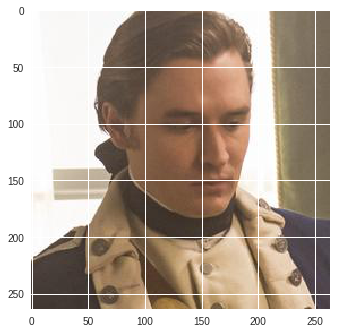

In [0]:
import matplotlib.pyplot as plt
img = plt.imread('data/train/282/nm6141957_rm1122684672_1732-2-22_2014.jpg')
plt.imshow(img)